# Anime Recommendation System
Authors: You XU(youx), 
         Qixuan WANG(qixuanw)


## Introduction
Welcome to the world of Animes! A lot of people like to watch animes in their spare time but they always suffer from  finding a new anime they like. Now imaging that you have a recommandation system that knows you taste so much and will recommend animes to you anytime you want to find new animes. Does it sounds great? 

In this project, we will show you how to make this come ture and build your own Anime Recommendation System based on LFM model.  

## Data Collection
In this part, we will show you how we collected data about users and animes from `anilist.co` ( https://anilist.co/ ). We will show you the distribution of the dataset we built and challenges we observed from it. We also stored data into csv files for future use.

### Working with APIs
 The first thing is to use the `anilist` api to get the data we want. Here we want the data of all the users and the animes they likes to analyze the users' preference. Also we need the animes popularity evaluated by users accordingly. Therefore, the goal of this part is to get two dictionaries:
  1. Dictionary of user and animes he/she takes action(favourite or review)
  2. Dictionary of anime and popularity
  
For security reason, we replace our token in this notebook with "YOUR_TOKEN". You can your own token follow the instruction here (http://anilist-api.readthedocs.io/en/latest/authentication.html).

In [1]:
import io, time, json
import requests
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt

Since the api does not provide us the users' favourite animes, it provide five catergories and status such as "watching", "completed", "on-hold", "dropped" and "plan to watch" for user to choose. Here we assume that the "completed" status means that the user likes the anime and shows the interest to the anime. Meanwhile, since the dictionary of users to favourite anime is very large and the token of accessing api will expire in one hour, we saved the data crawed from the website into a csv file so that we don't need to restart the cell everytime we open it. We keep records for 5000 different users in our experiment. 

In [2]:
def initUserAnimesDict():
    '''
    Get the dictionary of user and animes he/she takes action(favourite or review)
    key: User ID
    value: Anime ID list
    '''

    dit = {} 
    i = 1
    while i < 5000:
        completed_value = []
        i += 1
        url = "https://anilist.co/api/user/"+ str(i) + "/animelist/?access_token=" + "YOUR_TOKEN"
        response = requests.get(url)
        if response.status_code == "404":
            break
        else:
            content = json.loads(response.content)
            j = 0
            if "lists" in content:
                if "completed" in content["lists"]:
                    for j in range(len(content["lists"]["completed"])):
                        completed_value.append(content["lists"]["completed"][j]['anime']['id'])
                    dit[content['id']] = completed_value
            else:
                continue
    return dit

`anilist.co` also provides us with the popularity of each anime so that we can use it directly. The popularity is calculated by tracking the number of visited. Therefore, the popularity is represented with integer larger than zero. 

In [3]:
def initAnimePopularityDict():
    '''
    Get the dictionary of anime and popularity
    key: User ID
    value: Popularity
    '''
    ppl_dict = {}
    for i in animes:
        try:
            url = "https://anilist.co/api/anime/"+ str(i) + "/?access_token=" + "YOUR_TOKEN"
            response = requests.get(url)
            if response.status_code == "404":
                break
            else:
                content = json.loads(response.content)
                if "popularity" in content:
                    ppl_dict[i] = content['popularity']
                else:
                    continue
        except ConnectionError:
            continue
    return ppl_dict

## Data persistency
We stored data in two csv files so that we can read data from these files in our following analysis. 

In this part, we provide both the persistency code and the data recovery code.

In [4]:
def persistency(path, dict_to_saved):
    pd.DataFrame.from_dict(data = dict_to_saved, orient = 'index').to_csv(path, header=False)

In [5]:
persistency('/Users/youx/Desktop/dict_file_p', animes_pool)
persistency('/Users/youx/Desktop/dict_file_5000.csv', user_animes_dict)

In [6]:
def parse_int(s):
    try:
        res = int(eval(str(s)))
        if type(res) == int:
            return res
    except:
        return

'''
Read data and transform into user_anime dictionary
'''
def readCSVfile(path):
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    res = {}
    for item in reader:
        tmp = []
        for i in range(1, len(item)):
            if item[i] != '':
                tmp.append(parse_int(item[i]))
        res[int(item[0])] = tmp
    return res

'''
Read data and transform into anime popularity dictionary
'''
def readPopularity(path):
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    res = {}
    for item in reader:
        res[int(item[0])] = int(item[1])
    return res

In [7]:
ua_2000 = readCSVfile('/Users/youx/Desktop/data/dict_file_2000.csv')
ua_5000 = readCSVfile('/Users/youx/Desktop/data/dict_file_5000.csv')
user_animes_dict = {**ua_2000, **ua_5000}

In [8]:
ppl_1 = readPopularity('/Users/youx/Desktop/data/dict_file_p1.csv')
ppl_2 = readPopularity('/Users/youx/Desktop/data/dict_file_p2.csv')
ppl_3 = readPopularity('/Users/youx/Desktop/data/dict_file_p22.csv')
ppl_4 = readPopularity('/Users/youx/Desktop/data/dict_file_p3.csv')
ppl_5 = readPopularity('/Users/youx/Desktop/data/dict_file_p32.csv')
animes_pool = {**ppl_1, **ppl_2, **ppl_3, **ppl_4, **ppl_5}

In [9]:
animes_pool_pop = {}
for user,items in user_animes_dict.items():
    for item in items:
        if item not in animes_pool_pop:
            animes_pool_pop[item] = 0
        animes_pool_pop[item] += 1

# Data Visualization

To better understand the dataset, we draw the picture to analysis the data distribution and then filter some data that is unnecessary. The first picture is about how many animes the users have ever watched. X-axis represents the userId and Y-axis represents the number of animes the user has watched. For instance, for the point (200，500) means that the user whose id is 200 has watched 500 animes. The second picture is about the number of people who has watched the specific number of animes. X-axis represents the number of animes and Y-axis represents the number of people who have watched the specific number of animes. For instance, for the point (500，5) means that there are 5 people who have watched 500 animes.   

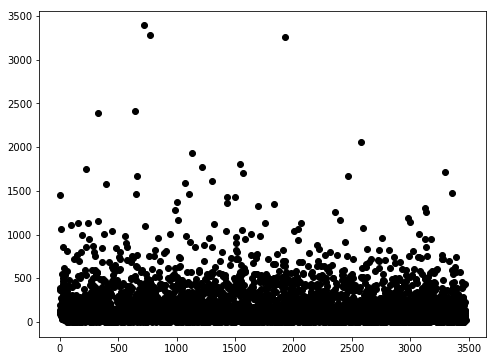

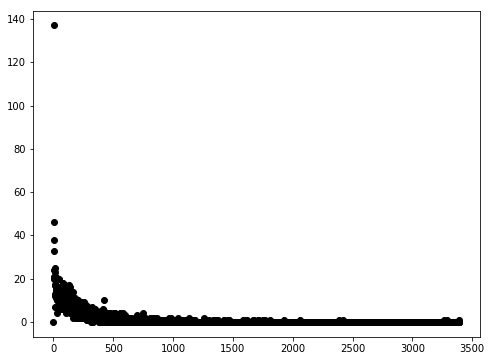

In [10]:
def draw():
    i = 0
    max_Value = 0
    x_num = []
    y_num = []
    for key in list(user_animes_dict):
        if len(user_animes_dict[key]) > max_Value:
            max_Value = len(user_animes_dict[key]) + 1
            
    lst = [0 for n in range(max_Value)]
    for key in list(user_animes_dict):
        x_num.append(i)
        y_num.append(len(user_animes_dict[key]))
        lst[len(user_animes_dict[key])] += 1
        i += 1
    return lst, max_Value, y_num, x_num 

y1, max_Value, y2, x2 = draw()
x1 = [n for n in range(max_Value)]
plt.figure(figsize=(8,6))
plt.plot(x2, y2, 'ko')

plt.figure(figsize=(8,6))
plt.plot(x1, y1, 'ko')
# plt.savefig('/Users/youx/Desktop/anime4.png', format='png', bbox_inches='tight', transparent=True, dpi=600) 
plt.show()

From the figure we can conclude that most users completed less than 400 animes. Therefore, the challenges including recommending animes to users with less than 20 samples.

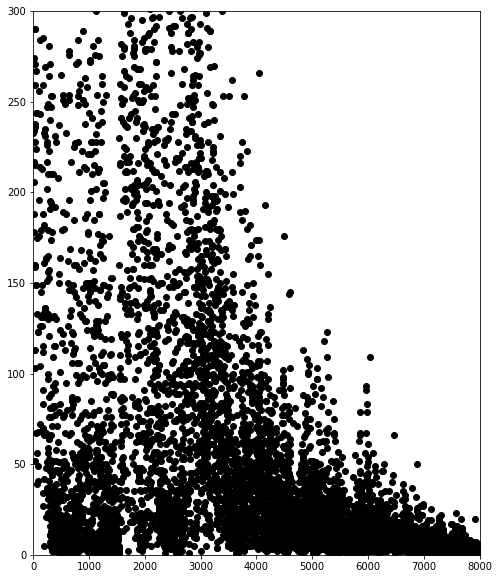

In [11]:
def drawAnime():
    i = 0
    x = []
    y = []
    for key in list(animes_pool_pop):
        x.append(i)
        y.append(animes_pool_pop[key])
        i += 1
    return x, y

x, y =drawAnime()
plt.figure(figsize=(8,10))
plt.axis([0, 8000, 0, 300])
plt.plot(x, y, 'ko')
plt.savefig('/Users/youx/Desktop/anime_pop.png', format='png', bbox_inches='tight', transparent=True, dpi=600) 
plt.show()

This figure is about how many people have ever watched a specfic anime. X-axis represents the animeId and Y-axis represents the number of people have watched this anime. For instance, for the point (200，500) means that the anime whose id is 200 has been watched by 500 people.

From the figures we can conclude that the data is sparse. From the first figure,  most users completed less than 500 animes. So the challenge is to recommend animes to users with less than 20 samples.

### Latent Factor Model


The Latent Factor Model is the most popular research topic in the recommendation system field in recent years. The goal is to get users ratings for each item. David Wheeler once said that "All problems in computer science can be solved by another level of indirection". LFM's core idea is just like this. It connects user interests and items through a latent factors layer(categories). The essence of the Latent Factor Model is to classify users and items. According to how is the user interested about each category and the weight of each item in each category, the user will be recommended items that he/she is most interested in. Therefore, the challenge of the recommendation system is to classify the items and user's interests and also determine the weight of items in each category. LFM gets user `u`'s interest in item `i` through the following model:

$$Preference(u,i) = r_{ui} = p_{u}^{\rm T}q_{i} = \sum^F_{k = 1}p_{u,k}q_{i,k}$$

In the model, `k` is the collections of implicit classes, $p_{uk}$ represents how user `u` interested in implicit class `k` and $q_{ik}$ represent the weight of item `i` in class `k`. Multiplying $p_{u}$ and $q_{i}$ we get user `u`'s rating on  item `i`.

#### Optimize loss function
Our loss function is shown below:

$$C = \sum_{(u,i)\in K}(r_ui - \hat{r_ui})^2 = \sum{(u,i) \in K}(r_{u,i} - \sum_{k = 1}^K{p_{u,k}q_{i,k}})^2 + \lambda{||p_{u}||}^2 + \lambda{||q_{i}||}^2 $$

We apply gradient descent to optimize `p` and `q`:

$$\frac{\partial{C}}{\partial{P_{uk}}}=2(r_{ui}- \sum_{k=1}^Kp_{uk}q_{ik})(-q_{ik})+2\lambda{p_{uk}}$$

$$\frac{\partial{C}}{\partial{q_{ik}}}=2(r_{ui}- \sum_{k=1}^Kp_{uk}q_{ik})(-p_{uk})+2\lambda{q_{ik}}$$


#### Choose positive and negative samples
In order to obtain p, q these two parameters, we need to take a number of positive and negative samples for each user to analyze user preferences. It is more convenient to obtain positive and negative samples in terms of anime scoring. However, for our invisible feedback dataset, we only have the positive samples. Thus the selection of negative samples is pretty important. In our project, we tried two different sampling strategies and we got a better result with the follwing strategy:

1. Ensure the number of negative samples is close to the positive samples.
2. When choosing negative samples, give items that are popular but user has no behavior about them higher priority.

The second point is logically reasonable. If an anime is very hot and popular, the user still does not choose this movie under the recommendation of relatives and friends and media promotion. It is estimated that this user really does not like it. Therefore, popular items that have not been selected are generally more likely to reflect a person's interest preference than unselected popular items.

In [12]:
'''
Random select negative samples

params:
 items: list of the users likes
 items_pool: dict of all animes and their popularities
 ratio: the ratio of negative samples
 strategy: random - random select negative samples
           prob - random select negative samples based on probilities
'''
import numpy as np
def selectNegativeSample(items, items_pool, ratio, strategy):
    ret = dict()
    for i in items:
        ret[i] = 1
    n = 0
    ids = list(items_pool.keys())
    sum_p = sum(items_pool.values())
    ngtvs = []
    if strategy == "random":
        ngtvs = np.random.choice(ids, len(items)*3)
    if strategy == "prob":
        probabilities = [ppl/sum_p for ppl in items_pool.values()]
        ngtvs = np.random.choice(ids, len(items)*3, p=probabilities)
    for ngtv in ngtvs:
        if ngtv in ret:
            continue
        ret[ngtv] = 0
        n += 1
        if n > len(items)*ratio:
            break
    return ret

In [13]:
'''
Optimize loss function
'''
import math
def predict(Puser, Qitem):
    rank = Puser@Qitem.T
    rank = 1/(1+math.exp(-rank)) 
    return rank

def initModel(users_pool, items_pool, F):
    n = len(users_pool)  
    m = len(items_pool)
    P = dict()
    Q = dict()
    for i in range(n):
        P[users_pool[i]] = np.random.rand(1,F)[0]
    for i in range(m):
        Q[items_pool[i]] = np.random.rand(1,F)[0]
    return P,Q

def LatentFactorModel(user_items, items_pool, F, N, alpha, flambda, falpha, ratio):
    users_pool = []
    for user, items in user_items.items():
        users_pool.append(user)
    P, Q = initModel(users_pool, list(items_pool.keys()), F)
    err_sum = 0
    for step in range(0,N):
        err_sum = 0
        for user, items in user_items.items():
            samples = selectNegativeSample(items, items_pool, ratio, "random")
            for item, rui in samples.items():
                eui = rui - predict(P[user], Q[item])
                err_sum += eui**2
                P[user] += alpha * (eui * Q[item] - flambda * P[user])
                Q[item] += alpha * (eui * P[user] - flambda * Q[item])
        alpha *= falpha
    return P, Q

## Experiment Preparation
In our following experiment, we split 10% of our data to the testing set and 90% to be the training set.

In [14]:
def splitData(data, k, seed):
    test = {}
    train = {}
    np.random.seed(seed)
    for user, item in data.items():
        for ani in item:
            if np.random.randint(0,k) == 1:
                if user not in test:
                    test[user] = []
                test[user].append(ani)
            else:
                if user not in train:
                    train[user] = []
                train[user].append(ani)
    return train, test

In [15]:
train, test = splitData(user_animes_dict, 10, 5)

## Recommendations
In this part, we complete the recommend function which calculated the user-anime rating matrix based on P and Q we trained with LFM. Since Q represents the weight of each anime in each category, we also visulize Q to get Top N animes in latent categories and check if they are reasonable. 

In [16]:
def recommend(user, P, Q, N):
    rank = dict()
    for item in Q.keys():
        if item not in rank:
            rank[item] = 0
        rank[item] = 1.0/(1+math.exp(-P[user]@Q[item].T)) 
    return sorted(rank.items(), key = lambda x: x[1], reverse = True)[0:N]

In [17]:
P,Q = LatentFactorModel(train, animes_pool, 20, 40, 0.02, 0.01, 0.9, 1)
recommend(2003, P, Q, 3)

[(967, 0.27889276391), (1356, 0.27654678876), (671, 0.26789901827)]


In [14]:
def topnAnimes(Q, n):
    df = pd.DataFrame(data=Q)
    dft = df.T 
    top_animes = {}
    for i in range(20):
        ten = list(dft.sort_values(by=i, ascending=False)[i].keys())[:n]
        top_animes[i] = ten
    res = {}
    for c, anis in top_animes.items():
        res[c] = []
        for ani in anis:
            url = "https://anilist.co/api/anime/" + str(ani) + "?access_token=" + "YOUR_TOKEN"
            response = requests.get(url)
            if response.status_code == "404":
                break
            else:
                content = json.loads(response.content)
                j = 0
                if "title_english" in content:
                    res[c].append(content['title_english'])
                else:
                    continue
    return pd.DataFrame(data=res)

topnAnimes(Q, 10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Hidamari Sketch: x365,Dragon Ball Z Movie 05: Cooler's Revenge,A Certain Magical Index II,Terror in Resonance,Azumanga Daioh: The Animation,07-Ghost,Shakugan no Shana III (Final),Ponyo,Log Horizon,Little Busters!,Baka and Test – Summon the Beasts 2,Re:ZERO -Starting Life in Another World-,HENNEKO – The Hentai Prince and the Stony Cat -,Mobile Suit Gundam 00 Second Season,Natsume's Book of Friends Sequel,Pokemon 3: The Movie,When They Cry,Junjou Romantica,The Tatami Galaxy,Digimon Tamers
1,Hidamari Sketch,Dragon Ball Z Movie 04: Lord Slug,Problem Children Are Coming From Another World...,Sword of the Stranger,Ghost in the Shell,Naruto Movie 3: Large Interest Stirred Up! Cre...,Aria the Scarlet Ammo,Grave of the Fireflies,Noragami,Ground Control to Psychoelectric Girl,Aria the Scarlet Ammo,Strike the Blood,High School DxD,Bakuman.,Blue Exorcist: The Movie,Pokemon: The First Movie,Detroit Metal City,Pokemon Heroes,Humanity Has Declined,Digimon: Digital Monsters 02
2,YuruYuri Season 2,Dragon Ball Z Movie 01: Dead Zone,Majikoi: Oh! Samurai Girls,Tokyo Ghoul,Redline,Bleach the Movie 2: The DiamondDust Rebellion,Nyarko-san: Another Crawling Chaos W,Black Butler II,My Teen Romantic Comedy SNAFU OVA,Naruto the Movie 2: Legend of the Stone of Gelel,The Familiar of Zero F,The Irregular at Magic High School,Oreshura,Nura: Rise of the Yokai Clan - Demon Capital,Natsume's Book of Friends Four,Pokemon: The Movie 2000,Serial Experiments Lain,Pokemon 3: The Movie,Tamako Market,Yu-Gi-Oh! GX
3,Joshiraku,Dragon Ball Z Movie 08: Broly - The Legendary ...,Horizon in the Middle of Nowhere,Akira,Gurren Lagann,Bleach,Infinite Stratos,Senyuu,White Album 2,Pokemon: The First Movie,High School DxD OVA,One Punch Man,Date A Live,Bleach the Movie 2: The DiamondDust Rebellion,Rainbow,Porco Rosso,Paprika,Junjou Romantica 2,The Place Promised in Our Early Days,Unlimited Psychic Squad
4,YuruYuri,Sailor Moon SuperS,Student Council's Discretion,Pale Cocoon,Spice and Wolf,Special A,Heaven's Lost Property: Forte,Recorder and Randsell,The Kawai Complex Guide to Manors and Hostel B...,Pokemon: The Movie 2000,The World God Only Knows OVA,No Game No Life,Haganai: Add-on Disc,Lovely★Complex,Hunter x Hunter,The Secret World of Arrietty,Haibane Renmei,D.Gray-man,Sayonara Zetsubou Sensei,Dragon Ball
5,AIURA,Dragon Ball Z Movie 11: Bio-Broly,Amagami SS,Kill la Kill,Cromartie High School,Tsubasa Chronicle,Haganai Next,Voices of a Distant Star,Kill la Kill,YuruYuri Season 2,Arakawa Under the Bridge x Bridge,Unbreakable Machine-Doll,Oreimo 2,Kimi ni Todoke 2nd Season,Natsume's Book of Friends,Howl‘s Moving Castle,Wandering Son,Black Butler,UN-GO,Kaze no Stigma
6,GJ Club,Pokemon 4Ever,Motto To Love Ru,Knights of Sidonia,Black Lagoon: The Second Barrage,Devil May Cry,Student Council's Discretion Level 2,Black Butler,Space☆Dandy,K-ON! Season 2,Heaven's Lost Property: Forte,The Seven Deadly Sins,The Pet Girl of Sakurasou,Final Fantasy VII: Advent Children,Natsume's Book of Friends Three,Evangelion: 1.0 You Are (Not) Alone,Cowboy Bebop,Naruto: Shippuden Movie 4 - The Lost Tower,Shiki,Nura: Rise of the Yokai Clan - Demon Capital
7,Yuyushiki,Sailor Moon S,My Teen Romantic Comedy SNAFU,Attack on Titan,When They Cry Rei,Kaze no Stigma,Black Bullet,Kuroko no Basket: Tip Off,Attack on Titan,Haganai Next,Beelzebub,Monthly Girls' Nozaki-kun,Haganai,Final Fantasy VII: Advent Children Complete,Kimi ni Todoke,Digimon: Digital Monsters,Voices of a Distant Star,The Sacred Blacksmith,La Maison en Petits Cubes,Digimon: Digital Monsters
8,Humanity Has Declined,Beyond the Boundary,Engaged to the Unidentified,Fate/stay night: Unlimited Blade Works,the Garden of sinners Chapter 4: garan-no-dou....,Bokurano,Mashiroiro Symphony,Recorder and Randsell Re,Free! Eternal Summer,The Troubled Life of Miss Kotoura,To Love Ru OVA,Kiznaiver,Btooom!,Bleach the Movie: Memories of Nobody,Kaiji - Ultimate Survivor,Jin-Roh: The Wolf Brigade,Princess Mononoke,The Fa

### Evaluation

The classification accuracy is defined as whether the recommendation algorithm prefers to determine the correct proportion for an item user. When the user has only binary selection, it is more appropriate to use the classification accuracy for evaluation. Typical Precision and Recall are used to evaluate a recommendation system. The accuracy rate indicates the user's interest in a recommended item.
$$Precision = \frac{N_{s}}{N_{r}}$$
$N_{r}$ represents the number of recommended items and $N_{s}$ represents the number of items the user likes in the recommended list. And recall rate is defined as the ratio of the user’s favorite products in the recommendation list to all products the user likes in the system.

$$ Recall = \frac{N_{s}}{N_{a}}$$

$N_{s}$ represents the number of items the user likes in the recommendation list, and $N_{a}$ represents the total number of products the user likes in the system. Since it is impossible to know whether the user likes some unknown product in a recommendation system, the recall rate is not suitable for measuring the recommender system in a pure sense. To be specific, the recall rate needs to know each user's preference of unselected products which is contrary to the original intention of the recommendation system. Therefore, here we use F indicator for comprehensive consideration of both Precision and Recall.

$$F = \frac{2PR}{P + R}$$

Overall, our recommendation system gets precision of 33.4%, coverage rate of 78.2% and popularity of 6.43. The result is good enough considered the sparsity of our data.


In [20]:
'''
Evaluation
'''
def precisionAndRecall(train, test, P, Q, N):
    hit = 0
    recommends = 0
    has_seen = 0
    for user in train.keys():
        if user in test:
            if len(test[user])>N:
                likes = test[user]
                rank = recommend(user, P, Q, N)
                for item, rui in rank:
                    if item in likes:
                        hit += 1
                recommends += N
                has_seen += len(likes)
    precision = hit/recommends
    recall = hit/has_seen
    f = precision*recall*2 / (precision+recall)
    return hit/recommends, hit/has_seen, f

def Coverage(train, test, P, Q, N):
    recommend_items = set()
    all_items = set()
    for user in train.keys():
        for item in train[user]:
            all_items.add(item)
        rank = recommend(user, P, Q, N)
        for item, rui in rank:
            recommend_items.add(item)
    return len(recommend_items)/len(all_items)

def Popularity(train, test, P, Q, N):
    item_popularity = dict()
    res = 0
    n = 0
    for user, items in train.items():
        for item in items:
            if item not in item_popularity:
                item_popularity[item] = 0
            item_popularity[item] += 1
    for user in train.keys():
        rank = recommend(user, P, Q, N)
        for item, rui in rank:
            if item in item_popularity:
                res += math.log(1 + item_popularity[item])
                n += 1
    res /= n
    return res

In [21]:
print(precisionAndRecall(train, test, P, Q, 40))
print(Coverage(train, test, P, Q, 40))
print(Popularity(train, test, P, Q, 40))

(0.3338646346929628, 0.13842919070546164, 0.19571126574324088)
0.782
6.433522961566083
